In [38]:
#0 사용할 패키지 불러오기
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

print('Desktop running: keras', keras.__version__)
np.random.seed(222)


Desktop running: keras 2.2.5


In [39]:
#코랩과 구글 드라이브 연동
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#1. 미리 학습된 모델 keras에서 불러오기
inceptionV3_model = keras.applications.inception_v3.InceptionV3()

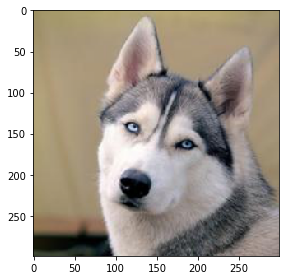

In [0]:
#2. 이미지 전처리 및 불러오기
Xi = skimage.io.imread('/content/gdrive/My Drive/LIME_image/husky.jpg')
Xi = skimage.transform.resize(Xi,(299,299))
Xi = (Xi - 0.5)*2
skimage.io.imshow(Xi/2+0.5)

In [0]:
#3. Inception V3 모델로 이미지 예측해보기
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0]

[('n02109961', 'Eskimo_dog', 0.5908675),
 ('n02110185', 'Siberian_husky', 0.29789415),
 ('n02091467', 'Norwegian_elkhound', 0.0013401792),
 ('n03218198', 'dogsled', 0.0013073562),
 ('n02114548', 'white_wolf', 0.0012720505)]

In [0]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes

array([248, 250, 174, 537, 270])

In [0]:
#4. 이미지 super-pixel로 추출하기
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200,ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

65

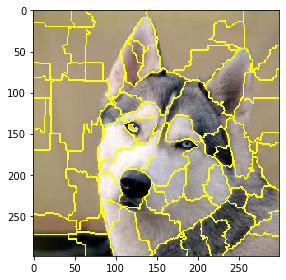

In [0]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5,superpixels))

In [0]:
#5.fake_data로 이미지 데이터 셋을 만든 후 랜덤하게 섞기
num_perturb = 200
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [0]:
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

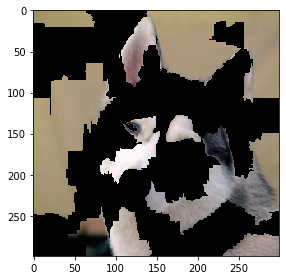

In [0]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [0]:
#6. 새로운 데이터셋으로 예측해보기
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)
    
predictions = np.array(predictions)
predictions.shape

(200, 1, 1000)

In [0]:
#7. 원래 이미지와 새로운 데이터셋 간의 거리 계산
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(200,)

In [0]:
#8. 커널함수로 consine distance를 0~1 사이로 보내기
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(200,)

In [0]:
#9. 선형모델로 근사시켜 각각의 변수의 계수들 출력하기
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain],sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.00138653,  0.03626248, -0.01509285,  0.03664986, -0.01900383,
       -0.01589945, -0.01000037, -0.01312043,  0.02449382, -0.01328861,
       -0.00155147, -0.03583112, -0.01363811, -0.01569839,  0.02384244,
        0.01450842,  0.02026483,  0.07746697, -0.00346075,  0.04749505,
       -0.03167982, -0.0093569 ,  0.03594006,  0.1136602 , -0.00564301,
        0.07544769,  0.01826928, -0.03668733,  0.05758218, -0.03292058,
       -0.00166559,  0.0140256 , -0.00834168, -0.00504222,  0.06921939,
        0.0236897 , -0.01348281,  0.04950411,  0.02415496,  0.04598951,
        0.02306353, -0.02424856, -0.00289624,  0.00283797,  0.00035094,
        0.01741693,  0.01923791,  0.04061934,  0.00988097,  0.02665374,
        0.04313154,  0.02771051, -0.00940199,  0.04908105, -0.01365951,
        0.01866412, -0.00747881, -0.00912487,  0.00121672,  0.00612387,
        0.00856409,  0.00056234,  0.01526692,  0.02247268,  0.01432712])

In [0]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:]
top_features

array([34, 25, 17, 23])

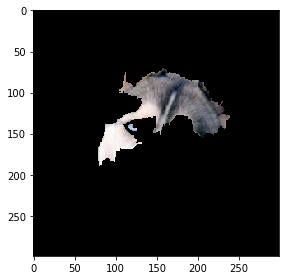

In [0]:
mask = np.zeros(num_superpixels)
mask[top_features] = True
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))